In [1]:
import os
import pandas as pd
from statsmodels.formula.api import ols
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import copy
import numpy as np

#df_transversal = pd.read_csv('C:/Users/samue/OneDrive/Documents/Samuel/UdeM/Honor/df_transversal.csv')
df_transversal = pd.read_csv(os.path.expanduser("~")+'/Dropbox/lab/samuel/df_transversal.csv')

In [2]:
from sklearn import preprocessing

x = df_transversal.values
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x[:,2:7])
df_transversal_scale = pd.DataFrame(x_scaled)
df_transversal_scale.columns = ['GDSTOT','STAITOT','STATE','TRAIT','MCA']
df_transversal_scale = pd.concat([df_transversal.iloc[:,0:2],df_transversal_scale], axis=1)
df_transversal_scale

,PATNO,APPRDX,GDSTOT,STAITOT,STATE,TRAIT,MCA
0,3000,2.0,0.307692,0.588235,0.424242,0.805556,0.933333
1,3001,1.0,0.307692,0.725490,0.818182,0.638889,1.000000
2,3002,1.0,0.384615,0.862745,0.787879,0.861111,0.933333
3,3003,1.0,0.230769,0.568627,0.606061,0.611111,0.866667
4,3004,2.0,0.230769,0.686275,0.666667,0.722222,0.733333
...,...,...,...,...,...,...,...
546,4124,1.0,0.384615,0.764706,0.696970,0.805556,0.466667
547,4126,1.0,0.384615,0.686275,0.727273,0.666667,0.800000
548,4135,1.0,0.384615,0.568627,0.636364,0.583333,0.666667
549,4136,NaN,0.538462,0.745098,1.000000,0.500000,0.466667


In [25]:
# PCA Analysis - Sélection des caractéristiques

import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

X = df_transversal.iloc[:,2:6].to_numpy()
y = df_transversal.columns[2:6]

scaler = MinMaxScaler()
X_echelle = scaler.fit_transform(X)

model_pca = PCA(n_components = 0.95)
model_pca.fit(X_echelle)
X_apres_pca = model_pca.transform(X_echelle)

model_pca.fit_transform(X_echelle)

ls_composantes = model_pca.components_
forme_composantes = ls_composantes.shape
nbr_composantes = forme_composantes[0]
# print(forme_composantes)

variance_expliquee = model_pca.explained_variance_ratio_

idx = []
for i in range(0,nbr_composantes):
    idx.append('PC'+str(i))
# print(pd.DataFrame(ls_composantes, columns=y, index=idx))

# Extraire la variance expliquée

dic_comps = {'PC{}'.format(i): variance_expliquee[i] for i in range(len(variance_expliquee))}
df_comps = pd.DataFrame(dic_comps.values(), index = dic_comps.keys(), columns=['explained_variance'])

# print(df_comps)

# Extraire les caractéristiques

most_important = [np.abs(ls_composantes[i]).argmax() for i in range(nbr_composantes)]
most_important_names = [y[most_important[i]] for i in range(nbr_composantes)]
dic_feat = {'PC{}'.format(i): most_important_names[i] for i in range(nbr_composantes)}
df_feat = pd.DataFrame(dic_feat.values(), index=dic_feat.keys(), columns=['features'])

# print(df_feat)

df_feat_comp = df_comps.join(df_feat, how='outer')
print(df_feat_comp)

     explained_variance features
PC0            0.643506  STAITOT
PC1            0.198553   GDSTOT
PC2            0.157941    TRAIT


In [ ]:
'''
C'est-à-dire que les scores du STAI permettent d'expliquer 64,35% de
la variance des différentes mesures

Par conséquent, et comme la taille d'échantillon est assez bonne (n=551), 
une régression linéaire sera exécutée afin
d'observer la corrélation entre le STAI et le MCA

Des tests post-hoc pourront être conduits afin d'observer à quels niveaux 
se situent les différences entre les 4 niveaux
(STAITOT PD, STAITOT HC, TRAIT PD, TRAIT HC) --> je ne sais pas encore s'il 
serait préférable d'observer les différences 
présentent entre (TRAIT PD, TRAIT HC, STATE PD, STATE HC) étant donné que 
ces groupes sont mutuellement exclusifs, ce qui
n'est pas le cas de la prremière option (TRAIT PD et compris dans STAITOT PD; 
même chose pour HC).

'''

In [ ]:
'''STATISTIQUES PLAN
1) Faire les statistiques descriptives pour chacune des colonnes du tableau

2) Vérifier les postulats de base de la régression linéaire

    À partir de l'analyse des résidus des termes de l'erreur estimée
    a) La relation entre Y et X est additive pour tout i,
    avec une fonction linéaire comme signal et une variable aléatoire comme bruit;

    b) E(ei) = 0;
    c) Les termes d'erreurs ei sont indépendants entre eux;
    d) Var(ei) = sigma^2; la variabilité du terme d'erreur 
    est constante et ne change pas en fonction des valeurs de X (homoscédasticité)

    Histogramme et QQ-plot des résidus des termes d'erreurs
    estimées et également test d'hypothèses de normalité

    e) ei ~ N(0,sigma^2) et donc Y|X ~ N(B0+B1X,sigma^2)
    
3) MÉTHODES:
    a) Régression linéaire 'MCA ~ STAITOT'
        i) pour TOUT (PD + HC)
        ii) pour PD/pour HC
        iii) post-hocs entre les groupes
    
    b) Régression linéaire 'MCA ~ GDSTOT'
        i) pour TOUT (PD + HC)
        ii) pour PD/pour HC
        iii) post-hocs entre les groupes
    
    c) Régression linéaire 'MCA ~ GDSTOT+STAITOT'
        i) pour TOUT (PD + HC)
        ii) pour PD/pour HC
        iii) post-hocs entre les groupes
    
''' 

In [29]:
# 1. Statistiques descriptives des variables quantitatives discrètes

stats_des = df_transversal.describe()
stats_des = stats_des.drop(columns=['PATNO','APPRDX'])
stats_des

,GDSTOT,STAITOT,STATE,TRAIT,MCA
count,551.000000,551.000000,551.000000,551.00000,551.000000
mean,5.303085,93.177858,47.252269,45.92559,26.629764
std,1.498111,7.298390,4.733620,4.20691,2.658938
min,1.000000,63.000000,27.000000,23.00000,15.000000
25%,5.000000,90.000000,44.000000,44.00000,25.000000
50%,5.000000,95.000000,48.000000,46.00000,27.000000
75%,6.000000,98.000000,50.000000,48.00000,29.000000
max,14.000000,114.000000,60.000000,59.00000,30.000000


In [40]:
# 1. Statistiques descriptives des variables quantitatives discrètes scaled

stats_des = df_transversal_scale.describe()
stats_des = stats_des.drop(columns=['PATNO','APPRDX'])
stats_des

,GDSTOT,STAITOT,STATE,TRAIT,MCA
count,551.000000,551.000000,551.000000,551.000000,551.000000
mean,0.331007,0.591723,0.613705,0.636822,0.775318
std,0.115239,0.143106,0.143443,0.116859,0.177263
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.307692,0.529412,0.515152,0.583333,0.666667
50%,0.307692,0.627451,0.636364,0.638889,0.800000
75%,0.384615,0.686275,0.696970,0.694444,0.933333
max,1.000000,1.000000,1.000000,1.000000,1.000000


In [6]:
# 1. Statistiques descriptives de la variable catégorielle (APPRDX)

stats_group = df_transversal.groupby('APPRDX').describe()
stats_group['freq'] = df_transversal.APPRDX.value_counts()
stats_group = stats_group[['freq', 'GDSTOT', 'STAITOT', 'STATE', 'TRAIT', 'MCA']]
pd.set_option('display.max_columns', 41)
print(stats_group)

       freq GDSTOT                                                STAITOT  \
             count      mean       std  min   25%  50%  75%   max   count   
APPRDX                                                                      
1.0     290  290.0  5.365517  1.524035  1.0  5.00  5.0  6.0  14.0   290.0   
2.0     158  158.0  5.272152  1.558411  1.0  4.25  5.0  6.0  10.0   158.0   

                                                             STATE             \
             mean       std   min    25%   50%   75%    max  count       mean   
APPRDX                                                                          
1.0     93.306897  6.799574  69.0  89.25  94.5  97.0  114.0  290.0  47.431034   
2.0     92.930380  7.362426  63.0  90.00  94.0  98.0  108.0  158.0  47.227848   

                                                TRAIT                       \
             std   min   25%   50%   75%   max  count       mean       std   
APPRDX                                              

In [41]:
# 1. Statistiques descriptives de la variable catégorielle (APPRDX) scaled

stats_group = df_transversal_scale.groupby('APPRDX').mean()
stats_group['freq'] = df_transversal_scale.APPRDX.value_counts()
stats_group = stats_group[['freq', 'GDSTOT', 'STAITOT', 'STATE', 'TRAIT', 'MCA']]
stats_group

,freq,GDSTOT,STAITOT,STATE,TRAIT,MCA
APPRDX,,,,,,
1.0,290,0.335809,0.594253,0.619122,0.635441,0.787816
2.0,158,0.328627,0.586870,0.612965,0.630626,0.751055


In [42]:
# 3.a.i Régression linéaire 'MCA ~ STAITOT' TOUT

# Créer un objet reg lin

model = ols(formula = 'MCA ~ STAITOT', data = df_transversal_scale).fit()

'''print(model.params)
# B0 (Intercept): valeur moyenne du MCA (26.51) dans la population quand STAITOT = 0
# B1 (pente): changement moyen du MCA dans la population pour un changement unitaire du GDSTOT
# --> Autrement dit, lorsque le GDSTOT varie de 1, le MCA augmente ne change pas.
'''
print(model.summary())
'''

# R^2 ajusté est de 0% ce qui est très faible
# Le AIC et le BIC sont assez élevés également --> signe que ce n'est 
peut-être pas le modèle idéal
# Le STAITOT ne permet pas de prédire le MCA de façon significative (p = 0.937)
# Asymétrie est bonne (entre -1 et 1), kurtosis est un peu élevée 
(devrait être entre -2 et 2) --> leptokurtique.'''

                            OLS Regression Results                            
Dep. Variable:                    MCA   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.002
Method:                 Least Squares   F-statistic:                  0.006344
Date:                Sun, 12 Apr 2020   Prob (F-statistic):              0.937
Time:                        14:51:48   Log-Likelihood:                 171.97
No. Observations:                 551   AIC:                            -339.9
Df Residuals:                     549   BIC:                            -331.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.7728      0.032     24.014      0.0

"\n\n# R^2 ajusté est de 0% ce qui est très faible\n# Le AIC et le BIC sont assez élevés également --> signe que ce n'est \npeut-être pas le modèle idéal\n# Le STAITOT ne permet pas de prédire le MCA de façon significative (p = 0.937)\n# Asymétrie est bonne (entre -1 et 1), kurtosis est un peu élevée \n(devrait être entre -2 et 2) --> leptokurtique."

In [34]:
print("intercept coef: ",model.params.Intercept,'\n',
    "intercept pvalue: ",model.pvalues.Intercept,'\n',
    "param coef: ",model.params.STAITOT,'\n',
      "param pvalue: ",model.pvalues.STAITOT,'\n',
    "rsquared: ",model.rsquared,'\n',
      "aic: ",model.aic,'\n',
      "bic: ",model.bic,'\n',)

NameError: name 'param' is not defined

In [43]:
# 3.a.ii Régression linéaire 'MCA ~ STAITOT' GROUP (PD/HC)

df_transversal_group_stai = df_transversal_scale.groupby('APPRDX')


for k, g in df_transversal_group_stai:
    model = ols('MCA ~ STAITOT', g)
    results = model.fit()
    print(results.summary())
    
''' s'il y a une différence dans la pred du MCA
Encore une fois rien de significatif autant dans le groupe PD que dans le groupe HCs'''

                            OLS Regression Results                            
Dep. Variable:                    MCA   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.003
Method:                 Least Squares   F-statistic:                    0.1025
Date:                Sun, 12 Apr 2020   Prob (F-statistic):              0.749
Time:                        14:51:57   Log-Likelihood:                 96.138
No. Observations:                 290   AIC:                            -188.3
Df Residuals:                     288   BIC:                            -180.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.8024      0.047     17.135      0.0

" s'il y a une différence dans la pred du MCA\nEncore une fois rien de significatif autant dans le groupe PD que dans le groupe HCs"

In [12]:
print("intercept coef: ",model.params.Intercept,'\n',
    "intercept pvalue: ",model.pvalues.Intercept,'\n',
    "param coef: ",model.params.STAITOT,'\n',
      "param pvalue: ",model.pvalues.STAITOT,'\n',
    "rsquared: ",model.rsquared,'\n',
      "aic: ",model.aic,'\n',
      "bic: ",model.bic,'\n',)

NameError: name 'param' is not defined

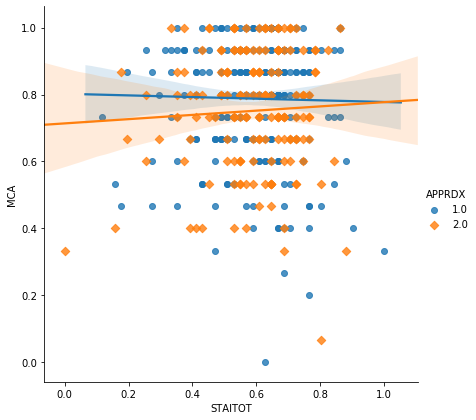

In [44]:
# Visualisation du MCA en fonction du STAI selon le groupe PD et le groupe HC

import seaborn as sns

g_stai = sns.pairplot(df_transversal_scale, x_vars=['STAITOT'], y_vars=['MCA'],
                hue='APPRDX', kind='reg', markers=['o','D'], height=6)

In [45]:
# Régression par quantiles 'MCA ~ STAITOT'

import statsmodels.formula.api as smf

mod = smf.quantreg('MCA ~ STAITOT', data = df_transversal_scale)
res = mod.fit(q=.5)
print(res.summary())

                         QuantReg Regression Results                          
Dep. Variable:                    MCA   Pseudo R-squared:           -1.872e-07
Model:                       QuantReg   Bandwidth:                      0.1068
Method:                 Least Squares   Sparsity:                       0.4540
Date:                Sun, 12 Apr 2020   No. Observations:                  551
Time:                        14:52:17   Df Residuals:                      549
                                        Df Model:                            1
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.8000      0.041     19.429      0.000       0.719       0.881
STAITOT     1.784e-06      0.068   2.64e-05      1.000      -0.133       0.133


In [15]:
print("intercept coef: ",model.params.Intercept,'\n',
    "intercept pvalue: ",model.pvalues.Intercept,'\n',
    "param coef: ",model.params.STAITOT,'\n',
      "param pvalue: ",model.pvalues.STAITOT,'\n',
    "rsquared: ",model.rsquared,'\n',
      "aic: ",model.aic,'\n',
      "bic: ",model.bic,'\n',)

NameError: name 'param' is not defined

     qt  intercept  STAITOT_coef  cf_lower_bound  cf_upper_bound
0  0.25   0.666668     -0.000001       -0.198320        0.198318
1  0.50   0.799999      0.000002       -0.132864        0.132867
2  0.75   0.933331      0.000003       -0.103009        0.103015


c:\users\samue\appdata\local\programs\python\python37-32\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  


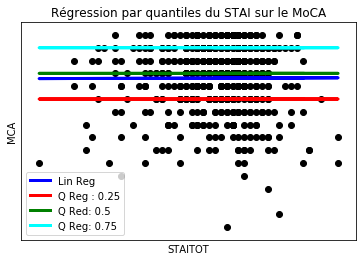

<Figure size 432x288 with 0 Axes>

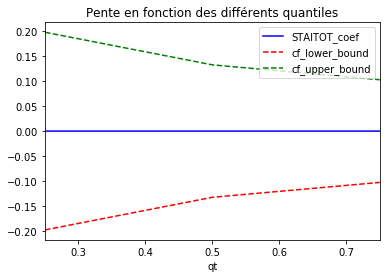

In [48]:
quantiles = np.arange(0.25,1,0.25)
models = []
params = []

for qt in quantiles:
    res = mod.fit(q = qt)
    models.append(res)
    params.append([qt, res.params['Intercept'], res.params['STAITOT']] + res.conf_int().ix['STAITOT'].tolist())
    
params = pd.DataFrame(data = params, columns = ['qt','intercept','STAITOT_coef','cf_lower_bound','cf_upper_bound'])

print(params)

x_ = df_transversal_scale.STAITOT.to_numpy().reshape(551,1)
y_ = df_transversal_scale.MCA
model2 = LinearRegression(fit_intercept=True,normalize=False)
model2.fit(x_,y_)
y_pred2 = model2.predict(x_)

plt.figure(1)
plt.scatter(x_, y_, color='black')
plt.plot(x_, y_pred2, color='blue',linewidth=3,label='Lin Reg')

y_pred3 = models[0].params['Intercept'] + models[0].params['STAITOT'] * x_
plt.plot(x_, y_pred3, color='red', linewidth=3, label='Q Reg : 0.25')

y_pred4 = models[1].params['Intercept'] + models[1].params['STAITOT'] * x_
plt.plot(x_, y_pred4, color='green', linewidth=3, label='Q Red: 0.5')

y_pred5 = models[2].params['Intercept'] + models[2].params['STAITOT'] * x_
plt.plot(x_, y_pred5, color='cyan', linewidth=3, label='Q Reg: 0.75')

plt.xticks(())
plt.yticks(())
plt.xlabel('STAITOT')
plt.ylabel('MCA')
plt.title('Régression par quantiles du STAI sur le MoCA')
plt.legend()

plt.figure(2)
params.plot(x = 'qt', y = ['STAITOT_coef','cf_lower_bound','cf_upper_bound'],
           title = 'Pente en fonction des différents quantiles',
           kind = 'line', style = ['b-','r--','g--'])

In [60]:
# Analyse par quantiles des scores du STAITOT sur le MCA

group_1_stai = []
group_2_stai = []
group_3_stai = []
group_4_stai = []

thresh = df_transversal.STAITOT.quantile([.25,.5,.75])
for i in range(len(df_transversal.index)):
    stai_val = df_transversal.at[i, "STAITOT"]
    if stai_val <= thresh.iloc[0]:
        group_1_stai.append([stai_val,df_transversal.at[i, "MCA"]])
    if stai_val > thresh.iloc[0] and stai_val <= thresh.iloc[1]:
        group_2_stai.append([stai_val,df_transversal.at[i, 'MCA']])
    if stai_val > thresh.iloc[1] and stai_val <= thresh.iloc[2]:
        group_3_stai.append([stai_val,df_transversal.at[i, 'MCA']])
    if stai_val > thresh.iloc[2]:
        group_4_stai.append([stai_val,df_transversal.at[i, "MCA"]])
        
arr_1_stai = np.array(group_1_stai)
arr_2_stai = np.array(group_2_stai)
arr_3_stai = np.array(group_3_stai)
arr_4_stai = np.array(group_4_stai)

slope, intercept, r_value, p_value, std_err = linregress(arr_1_stai[:,0],arr_1_stai[:,1])

df_arr_1_stai = pd.DataFrame(columns = ['group','slope','intercept','r^2_value','p_value','std_err'], index = range(0,1))
df_arr_1_stai['group'] = 'group_1_stai'
df_arr_1_stai['slope'] = slope
df_arr_1_stai['intercept'] = intercept
df_arr_1_stai['r^2_value'] = r_value**2
df_arr_1_stai['p_value'] = p_value
df_arr_1_stai['std_err'] = std_err

slope, intercept, r_value, p_value, std_err = linregress(arr_2_stai[:,0],arr_2_stai[:,1])

df_arr_2_stai = pd.DataFrame(columns = ['group','slope','intercept','r^2_value','p_value','std_err'], index = range(0,1))
df_arr_2_stai['group'] = 'group_2_stai'
df_arr_2_stai['slope'] = slope
df_arr_2_stai['intercept'] = intercept
df_arr_2_stai['r^2_value'] = r_value**2
df_arr_2_stai['p_value'] = p_value
df_arr_2_stai['std_err'] = std_err

slope, intercept, r_value, p_value, std_err = linregress(arr_3_stai[:,0],arr_3_stai[:,1])

df_arr_3_stai = pd.DataFrame(columns = ['group','slope','intercept','r^2_value','p_value','std_err'], index = range(0,1))
df_arr_3_stai['group'] = 'group_3_stai'
df_arr_3_stai['slope'] = slope
df_arr_3_stai['intercept'] = intercept
df_arr_3_stai['r^2_value'] = r_value**2
df_arr_3_stai['p_value'] = p_value
df_arr_3_stai['std_err'] = std_err

slope, intercept, r_value, p_value, std_err = linregress(arr_4_stai[:,0],arr_4_stai[:,1])

df_arr_4_stai = pd.DataFrame(columns = ['group','slope','intercept','r^2_value','p_value','std_err'], index = range(0,1))
df_arr_4_stai['group'] = 'group_4_stai'
df_arr_4_stai['slope'] = slope
df_arr_4_stai['intercept'] = intercept
df_arr_4_stai['r^2_value'] = r_value**2
df_arr_4_stai['p_value'] = p_value
df_arr_4_stai['std_err'] = std_err

quantiles_array_stai = [df_arr_1_stai,df_arr_2_stai,df_arr_3_stai,df_arr_4_stai]
results_quantiles_array_stai = pd.concat(quantiles_array_stai)
results_quantiles_array_stai


,group,slope,intercept,r^2_value,p_value,std_err
0,group_1_stai,0.090790,18.791083,0.036962,0.013652,0.036410
0,group_2_stai,-0.105560,36.771863,0.004065,0.449355,0.139151
0,group_3_stai,-0.231527,49.364532,0.004919,0.411981,0.281347
0,group_4_stai,-0.219255,48.449512,0.053136,0.017994,0.091197


In [61]:
# Correction des p-values avec Bonferroni

from statsmodels.stats.multitest import multipletests

multipletests(results_quantiles_array_stai.p_value, alpha=0.05, method='bonferroni')

(array([False, False, False, False]),
 array([0.05460672, 1.        , 1.        , 0.07197775]),
 0.012741455098566168,
 0.0125)

In [47]:
# Tester l'hypothèse selon laquelle le groupe 4 du STAI aurait une plus grande proportion de STATE que les autres groupes #

group_1_stai = []
group_2_stai = []
group_3_stai = []
group_4_stai = []

quantiles_stai = df_transversal.STAITOT.quantile([.25,.5,.75])

for val in df_transversal.STAITOT:
    if df_transversal.STAITOT[val] <= quantiles_stai.iloc[0]:
        group_1_stai.append([df_transversal.STAITOT[val],df_transversal.STATE[val],df_transversal.TRAIT[val],df_transversal.MCA[val]])
    if df_transversal.STAITOT[val] > quantiles_stai.iloc[0] and df_transversal.STAITOT[val] <= quantiles_stai.iloc[1]:
        group_2_stai.append([df_transversal.STAITOT[val],df_transversal.STATE[val],df_transversal.TRAIT[val],df_transversal.MCA[val]])
    if df_transversal.STAITOT[val] > quantiles_stai.iloc[1] and df_transversal.STAITOT[val] <= quantiles_stai.iloc[2]:
        group_3_stai.append([df_transversal.STAITOT[val],df_transversal.STATE[val],df_transversal.TRAIT[val],df_transversal.MCA[val]])
    if df_transversal.STAITOT[val] > quantiles_stai.iloc[2]:
        group_4_stai.append([df_transversal.STAITOT[val],df_transversal.STATE[val],df_transversal.TRAIT[val],df_transversal.MCA[val]])

In [48]:
group_1_state = pd.DataFrame(group_1_stai)
group_1_state.columns = ['STAITOT','STATE','TRAIT','MCA']
group_1_state.describe()

# Proportion STATE/STAITOT médiane = 48,68%

,STAITOT,STATE,TRAIT,MCA
count,212.000000,212.000000,212.000000,212.000000
mean,79.500000,38.051887,41.448113,24.481132
std,7.177176,5.076864,2.835480,2.672419
min,71.000000,31.000000,36.000000,21.000000
25%,71.000000,31.000000,39.000000,21.000000
50%,76.000000,37.000000,40.000000,24.000000
75%,87.000000,42.000000,44.000000,26.000000
max,90.000000,46.000000,48.000000,30.000000


In [49]:
group_2_state = pd.DataFrame(group_2_stai)
group_2_state.columns = ['STAITOT','STATE','TRAIT','MCA']
group_2_state.describe()

# Proportion STATE/STAITOT médiane = 52,17%

,STAITOT,STATE,TRAIT,MCA
count,136.000000,136.000000,136.000000,136.000000
mean,92.595588,47.669118,44.926471,26.985294
std,1.213374,1.161450,1.303172,2.273797
min,91.000000,46.000000,43.000000,23.000000
25%,92.000000,46.000000,44.750000,26.000000
50%,92.000000,48.000000,45.000000,27.000000
75%,94.000000,49.000000,46.000000,29.000000
max,95.000000,50.000000,49.000000,30.000000


In [50]:
group_3_state = pd.DataFrame(group_3_stai)
group_3_state.columns = ['STAITOT','STATE','TRAIT','MCA']
group_3_state.describe()

# Proportion STATE/STAITOT médiane = 51,55%

,STAITOT,STATE,TRAIT,MCA
count,151.00000,151.000000,151.000000,151.000000
mean,97.05298,49.682119,47.370861,27.788079
std,0.72836,0.859231,1.208944,2.080414
min,96.00000,48.000000,44.000000,24.000000
25%,97.00000,49.000000,46.000000,26.000000
50%,97.00000,50.000000,47.000000,28.000000
75%,98.00000,50.000000,48.000000,30.000000
max,98.00000,53.000000,50.000000,30.000000


In [44]:
group_4_state = pd.DataFrame(group_4_stai)
group_4_state.columns = ['STAITOT','STATE','TRAIT','MCA']
group_4_state.describe()

# Proportion STATE/STAITOT médiane = 50,94%

,STAITOT,STATE,TRAIT,MCA
count,52.000000,52.000000,52.000000,52.000000
mean,103.826923,52.480769,51.346154,24.384615
std,2.948720,2.469344,1.355954,1.190713
min,99.000000,46.000000,49.000000,24.000000
25%,100.000000,51.000000,50.000000,24.000000
50%,106.000000,54.000000,52.000000,24.000000
75%,106.000000,54.000000,52.000000,24.000000
max,106.000000,54.000000,53.000000,29.000000


In [51]:
'''L'hypothèse selon laquelle le groupe 4 aurait présenté une plus grande proportion d'anxiété d'état que les autres
groupes permettant ainsi d'expliquer pourquoi ce résultat n'est pas consistant avec les autres est rejetée.'''

"L'hypothèse selon laquelle le groupe 4 aurait présenté une plus grande proportion d'anxiété d'état que les autres\ngroupes permettant ainsi d'expliquer pourquoi ce résultat n'est pas consistant avec les autres est rejetée."

In [71]:
# Régression linéaire 'MCA ~ GDSTOT' TOUT

# Créer un objet reg lin

model = ols(formula = 'MCA ~ GDSTOT', data = df_transversal_scale).fit()

'''print(model.params)
# B0 (Intercept): valeur moyenne du MCA dans la population quand GDSTOT = 0
# B1 (pente): changement moyen du MCA dans la population pour un changement unitaire du GDSTOT
# --> Autrement dit, lorsque le GDSTOT varie de 1, le MCA diminue de -0.1314
'''

print(model.summary())
'''

# R^2 ajusté est de 0.4% ce qui est très faible
# Le AIC et le BIC sont assez élevés également --> signe que ce n'est 
peut-être pas le modèle idéal
# Le GDSTOT ne permet pas de prédire le MCA de façon significative (p = 0.083)
# Asymétrie est bonne (entre -1 et 1), kurtosis est un peu élevée 
(devrait être entre -2 et 2) --> leptokurtique.'''

                            OLS Regression Results                            
Dep. Variable:                    MCA   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     3.025
Date:                Sun, 12 Apr 2020   Prob (F-statistic):             0.0826
Time:                        15:40:42   Log-Likelihood:                 173.48
No. Observations:                 551   AIC:                            -343.0
Df Residuals:                     549   BIC:                            -334.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.8130      0.023     35.434      0.0

"\n\n# R^2 ajusté est de 0.4% ce qui est très faible\n# Le AIC et le BIC sont assez élevés également --> signe que ce n'est \npeut-être pas le modèle idéal\n# Le GDSTOT ne permet pas de prédire le MCA de façon significative (p = 0.083)\n# Asymétrie est bonne (entre -1 et 1), kurtosis est un peu élevée \n(devrait être entre -2 et 2) --> leptokurtique."

In [72]:
# Régression linéaire 'MCA ~ GDSTOT' GROUP (PD/HC)

df_transversal_group_gds = df_transversal_scale.groupby('APPRDX')


for k, g in df_transversal_group_gds:
    model = ols('MCA ~ GDSTOT', g)
    results = model.fit()
    print(results.summary())
    
''' s'il y a une différence dans la pred du MCA'''

                            OLS Regression Results                            
Dep. Variable:                    MCA   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.030
Date:                Sun, 12 Apr 2020   Prob (F-statistic):              0.311
Time:                        15:40:53   Log-Likelihood:                 96.604
No. Observations:                 290   AIC:                            -189.2
Df Residuals:                     288   BIC:                            -181.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.8176      0.031     26.330      0.0

" s'il y a une différence dans la pred du MCA"

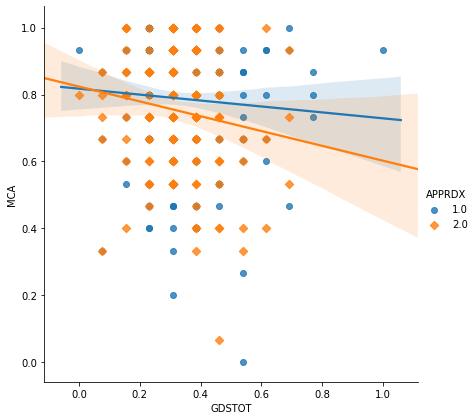

In [73]:
# Visualisation du MCA en fonction du GDS selon le groupe PD et le groupe HC

g_gds = sns.pairplot(df_transversal_scale, x_vars=['GDSTOT'], y_vars=['MCA'],
                hue='APPRDX', kind='reg', markers=['o','D'], height=6)

In [74]:
# Régression par qunantiles 'MCA ~ GDSTOT'

mod = smf.quantreg('MCA ~ GDSTOT', data = df_transversal_scale)
res = mod.fit(q=.5)
print(res.summary())

                         QuantReg Regression Results                          
Dep. Variable:                    MCA   Pseudo R-squared:           -1.790e-07
Model:                       QuantReg   Bandwidth:                      0.1068
Method:                 Least Squares   Sparsity:                       0.4540
Date:                Sun, 12 Apr 2020   No. Observations:                  551
Time:                        15:41:09   Df Residuals:                      549
                                        Df Model:                            1
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.8000      0.029     27.176      0.000       0.742       0.858
GDSTOT     -3.835e-06      0.084  -4.57e-05      1.000      -0.165       0.165


    qt  intercept   GDSTOT_coef  cf_lower_bound  cf_upper_bound
0  0.5  27.000002 -3.534444e-07       -0.190378        0.190378


c:\users\samue\appdata\local\programs\python\python37-32\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  
c:\users\samue\appdata\local\programs\python\python37-32\lib\site-packages\pandas\plotting\_matplotlib\core.py:1085: UserWarning: Attempting to set identical left == right == 0.5 results in singular transformations; automatically expanding.
  ax.set_xlim(left, right)


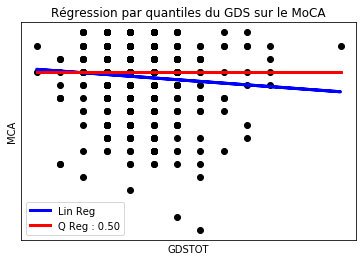

<Figure size 432x288 with 0 Axes>

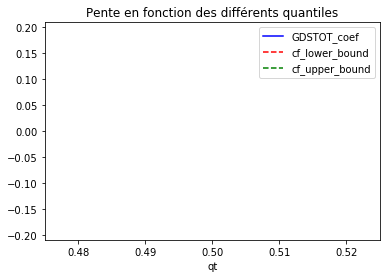

In [25]:
quantiles = np.arange(0.5,1,0.5)
models = []
params = []

for qt in quantiles:
    res = mod.fit(q = qt)
    models.append(res)
    params.append([qt, res.params['Intercept'], res.params['GDSTOT']] + res.conf_int().ix['GDSTOT'].tolist())
    
params = pd.DataFrame(data = params, columns = ['qt','intercept','GDSTOT_coef','cf_lower_bound','cf_upper_bound'])

print(params)

x_ = df_transversal.GDSTOT.to_numpy().reshape(551,1)
y_ = df_transversal.MCA
model2 = LinearRegression(fit_intercept=True,normalize=False)
model2.fit(x_,y_)
y_pred2 = model2.predict(x_)

plt.figure(3)
plt.scatter(x_, y_, color='black')
plt.plot(x_, y_pred2, color='blue',linewidth=3,label='Lin Reg')

y_pred3 = models[0].params['Intercept'] + models[0].params['GDSTOT'] * x_
plt.plot(x_, y_pred3, color='red', linewidth=3, label='Q Reg : 0.50')

plt.xticks(())
plt.yticks(())
plt.xlabel('GDSTOT')
plt.ylabel('MCA')
plt.title('Régression par quantiles du GDS sur le MoCA')
plt.legend()

plt.figure(4)
params.plot(x = 'qt', y = ['GDSTOT_coef','cf_lower_bound','cf_upper_bound'],
           title = 'Pente en fonction des différents quantiles',
           kind = 'line', style = ['b-','r--','g--'])

In [25]:
# Régression par quantiles des scores du GDSTOT sur le MCA

group_1_gds = []
group_2_gds = []

thresh = df_transversal.GDSTOT.quantile([.5]).iloc[0]
for i in range(len(df_transversal.index)):
    gds_val = df_transversal.at[i, "GDSTOT"]
    if gds_val <= thresh:
        group_1_gds.append([gds_val,df_transversal.at[i, "MCA"]])
    else:
        group_2_gds.append([gds_val,df_transversal.at[i, "MCA"]])
        
arr_1 = np.array(group_1_gds)
arr_2 = np.array(group_2_gds)

slope, intercept, r_value, p_value, std_err = linregress(arr_1[:,0],arr_1[:,1])

df_arr_1_gds = pd.DataFrame(columns = ['group','slope','intercept','r^2_value','p_value','std_err'], index = range(0,1))
df_arr_1_gds['group'] = 'group_1_gds'
df_arr_1_gds['slope'] = slope
df_arr_1_gds['intercept'] = intercept
df_arr_1_gds['r^2_value'] = r_value**2
df_arr_1_gds['p_value'] = p_value
df_arr_1_gds['std_err'] = std_err
df_arr_1_gds

slope, intercept, r_value, p_value, std_err = linregress(arr_2[:,0],arr_2[:,1])

df_arr_2_gds = pd.DataFrame(columns = ['group','slope','intercept','r^2_value','p_value','std_err'], index = range(0,1))
df_arr_2_gds['group'] = 'group_2_gds'
df_arr_2_gds['slope'] = slope
df_arr_2_gds['intercept'] = intercept
df_arr_2_gds['r^2_value'] = r_value**2
df_arr_2_gds['p_value'] = p_value
df_arr_2_gds['std_err'] = std_err
df_arr_2_gds

quantile_array_gds = [df_arr_1_gds,df_arr_2_gds]
results_quantile_array_gds = pd.concat(quantile_array_gds)
results_quantile_array_gds

,group,slope,intercept,r^2_value,p_value,std_err
0,group_1_gds,0.329890,25.429425,0.010713,0.048469,0.166618
0,group_2_gds,0.033133,25.847545,0.000227,0.837797,0.161622


In [27]:
# Correction des p-values avec Bonferroni

from statsmodels.stats.multitest import multipletests

multipletests(results_quantile_array_gds.p_value, alpha=0.05, method='bonferroni')

(array([False, False]),
 array([0.09693878, 1.        ]),
 0.025320565519103666,
 0.025)

In [62]:
'''Analysis not used anymore'''

'Analysis not used anymore'

In [26]:
# 3.a.ii Régression linéaire 'MCA ~ STAITOT' basé sur la performance (4 groupes)

from scipy.stats import linregress

group_1_stai = []
group_2_stai = []
group_3_stai = []
group_4_stai = []

quantiles_stai = df_transversal.STAITOT.quantile([.25,.5,.75])

for val in df_transversal.STAITOT:
    if df_transversal.STAITOT[val] <= quantiles_stai.iloc[0]:
        group_1_stai.append([df_transversal.STAITOT[val],df_transversal.MCA[val]])
    if df_transversal.STAITOT[val] > quantiles_stai.iloc[0] and df_transversal.STAITOT[val] <= quantiles_stai.iloc[1]:
        group_2_stai.append([df_transversal.STAITOT[val],df_transversal.MCA[val]])
    if df_transversal.STAITOT[val] > quantiles_stai.iloc[1] and df_transversal.STAITOT[val] <= quantiles_stai.iloc[2]:
        group_3_stai.append([df_transversal.STAITOT[val],df_transversal.MCA[val]])
    if df_transversal.STAITOT[val] > quantiles_stai.iloc[2]:
        group_4_stai.append([df_transversal.STAITOT[val],df_transversal.MCA[val]])
        
# Régression linéaire 'MCA ~ STAITOT_1'

X_1_stai = []
Y_1_stai = []

for i in range(0,len(group_1_stai)):
    X_1_stai.append(group_1_stai[i][0])

for i in range(0,len(group_1_stai)):
    Y_1_stai.append(group_1_stai[i][1])
    
X_1_stai = np.asarray(X_1_stai)
Y_1_stai = np.asarray(Y_1_stai)

X_1_stai = X_1_stai[:,np.newaxis]
Y_1_stai = Y_1_stai[:,np.newaxis]

slope, intercept, r_value, p_value, std_err = linregress(X_1_stai[:,0],Y_1_stai[:,0])

df_quantile_1_stai = pd.DataFrame(columns = ['group','slope','intercept','r^2_value','p_value','std_err'], index = range(0,1))
df_quantile_1_stai['group'] = 'group_1_stai'
df_quantile_1_stai['slope'] = slope
df_quantile_1_stai['intercept'] = intercept
df_quantile_1_stai['r^2_value'] = r_value**2
df_quantile_1_stai['p_value'] = p_value
df_quantile_1_stai['std_err'] = std_err

# df_quantile_1_stai

# Régression linéaire 'MCA ~ STAITOT_2'

X_2_stai = []
Y_2_stai = []

for i in range(0,len(group_2_stai)):
    X_2_stai.append(group_2_stai[i][0])

for i in range(0,len(group_2_stai)):
    Y_2_stai.append(group_2_stai[i][1])
    
X_2_stai = np.asarray(X_2_stai)
Y_2_stai = np.asarray(Y_2_stai)

X_2_stai = X_2_stai[:,np.newaxis]
Y_2_stai = Y_2_stai[:,np.newaxis]

slope, intercept, r_value, p_value, std_err = linregress(X_2_stai[:,0],Y_2_stai[:,0])

df_quantile_2_stai = pd.DataFrame(columns = ['group','slope','intercept','r^2_value','p_value','std_err'], index = range(0,1))
df_quantile_2_stai['group'] = 'group_2_stai'
df_quantile_2_stai['slope'] = slope
df_quantile_2_stai['intercept'] = intercept
df_quantile_2_stai['r^2_value'] = r_value**2
df_quantile_2_stai['p_value'] = p_value
df_quantile_2_stai['std_err'] = std_err

# df_quantile_2_stai

# Régression linéaire 'MCA ~ STAITOT_3'

X_3_stai = []
Y_3_stai = []

for i in range(0,len(group_3_stai)):
    X_3_stai.append(group_3_stai[i][0])

for i in range(0,len(group_3_stai)):
    Y_3_stai.append(group_3_stai[i][1])
    
X_3_stai = np.asarray(X_3_stai)
Y_3_stai = np.asarray(Y_3_stai)

X_3_stai = X_3_stai[:,np.newaxis]
Y_3_stai = Y_3_stai[:,np.newaxis]

slope, intercept, r_value, p_value, std_err = linregress(X_3_stai[:,0],Y_3_stai[:,0])

df_quantile_3_stai = pd.DataFrame(columns = ['group','slope','intercept','r^2_value','p_value','std_err'], index = range(0,1))
df_quantile_3_stai['group'] = 'group_3_stai'
df_quantile_3_stai['slope'] = slope
df_quantile_3_stai['intercept'] = intercept
df_quantile_3_stai['r^2_value'] = r_value**2
df_quantile_3_stai['p_value'] = p_value
df_quantile_3_stai['std_err'] = std_err

# df_quantile_3_stai

# Régression linéaire 'MCA ~ STAITOT_4'

X_4_stai = []
Y_4_stai = []

for i in range(0,len(group_4_stai)):
    X_4_stai.append(group_4_stai[i][0])

for i in range(0,len(group_4_stai)):
    Y_4_stai.append(group_4_stai[i][1])
    
X_4_stai = np.asarray(X_4_stai)
Y_4_stai = np.asarray(Y_4_stai)

X_4_stai = X_4_stai[:,np.newaxis]
Y_4_stai = Y_4_stai[:,np.newaxis]

slope, intercept, r_value, p_value, std_err = linregress(X_4_stai[:,0],Y_4_stai[:,0])

df_quantile_4_stai = pd.DataFrame(columns = ['group','slope','intercept','r^2_value','p_value','std_err'], index = range(0,1))
df_quantile_4_stai['group'] = 'group_4_stai'
df_quantile_4_stai['slope'] = slope
df_quantile_4_stai['intercept'] = intercept
df_quantile_4_stai['r^2_value'] = r_value**2
df_quantile_4_stai['p_value'] = p_value
df_quantile_4_stai['std_err'] = std_err

# df_quantile_4_stai

quantiles_stai = [df_quantile_1_stai,df_quantile_2_stai,df_quantile_3_stai,df_quantile_4_stai]
results_quantiles_stai = pd.concat(quantiles_stai)
results_quantiles_stai

,group,slope,intercept,r^2_value,p_value,std_err
0,group_1_stai,0.321833,-1.104570,0.747065,1.314743e-64,0.012922
0,group_2_stai,-0.547446,77.676335,0.085343,5.585032e-04,0.154822
0,group_3_stai,-1.599784,183.051848,0.313700,7.595751e-14,0.193851
0,group_4_stai,-0.116224,36.451754,0.082840,3.854130e-02,0.054690


In [20]:
# Correction des p-values avec Bonferroni

from statsmodels.stats.multitest import multipletests

multipletests(results_quantiles_stai.p_value, alpha=0.05, method='bonferroni')

(array([ True,  True,  True, False]),
 array([5.25897020e-64, 2.23401271e-03, 3.03830047e-13, 1.54165182e-01]),
 0.012741455098566168,
 0.0125)

In [50]:
# Régression linéaire 'MCA ~ GDSTOT' basé sur la performance (2 groupes)

quantiles_gds = df_transversal.GDSTOT.quantile([.5])

group_1_gds = []
group_2_gds = []

for val in df_transversal.GDSTOT:
    if df_transversal.GDSTOT[val] <= quantiles_gds.iloc[0]:
        group_1_gds.append([df_transversal.GDSTOT[val],df_transversal.MCA[val]])
    else:
        group_2_gds.append([df_transversal.GDSTOT[val],df_transversal.MCA[val]])

# Régression linéaire 'MCA ~ GDSTOT_1'

X_1_gds = []
Y_1_gds = []

for i in range(0,len(group_1_gds)):
    X_1_gds.append(group_1_gds[i][0])

for i in range(0,len(group_1_gds)):
    Y_1_gds.append(group_1_gds[i][1])
    
X_1_gds = np.asarray(X_1_gds)
Y_1_gds = np.asarray(Y_1_gds)

X_1_gds = X_1_gds[:,np.newaxis]
Y_1_gds = Y_1_gds[:,np.newaxis]

slope, intercept, r_value, p_value, std_err = linregress(X_1_gds[:,0],Y_1_gds[:,0])

df_quantile_1_gds = pd.DataFrame(columns = ['group','slope','intercept','r^2_value','p_value','std_err'], index = range(0,1))
df_quantile_1_gds['group'] = 'group_1_gds'
df_quantile_1_gds['slope'] = slope
df_quantile_1_gds['intercept'] = intercept
df_quantile_1_gds['r^2_value'] = r_value**2
df_quantile_1_gds['p_value'] = p_value
df_quantile_1_gds['std_err'] = std_err

# df_quantile_1_gds

# Régression linéaire 'MCA ~ GDSTOT_2'

X_2_gds = []
Y_2_gds = []

for i in range(0,len(group_2_gds)):
    X_2_gds.append(group_2_gds[i][0])

for i in range(0,len(group_2_gds)):
    Y_2_gds.append(group_2_gds[i][1])
    
X_2_gds = np.asarray(X_2_gds)
Y_2_gds = np.asarray(Y_2_gds)

X_2_gds = X_2_gds[:,np.newaxis]
Y_2_gds = Y_2_gds[:,np.newaxis]

slope, intercept, r_value, p_value, std_err = linregress(X_2_gds[:,0],Y_2_gds[:,0])

df_quantile_2_gds = pd.DataFrame(columns = ['group','slope','intercept','r^2_value','p_value','std_err'], index = range(0,1))
df_quantile_2_gds['group'] = 'group_2_gds'
df_quantile_2_gds['slope'] = slope
df_quantile_2_gds['intercept'] = intercept
df_quantile_2_gds['r^2_value'] = r_value**2
df_quantile_2_gds['p_value'] = p_value
df_quantile_2_gds['std_err'] = std_err

# df_quantile_2_gds

quantiles_gds = [df_quantile_1_gds,df_quantile_2_gds]
results_quantiles_gds = pd.concat(quantiles_gds)
results_quantiles_gds

,group,slope,intercept,r^2_value,p_value,std_err
0,group_1_gds,1.348868,20.552173,0.334163,5.039344e-49,0.082473
0,group_2_gds,1.000000,23.000000,1.000000,2.681250e-139,0.000000


In [27]:
# Correction des p-values avec Bonferroni

multipletests(results_quantiles_gds.p_value, alpha=0.05, method='bonferroni')

(array([ True,  True]),
 array([1.00786883e-048, 5.36250000e-139]),
 0.025320565519103666,
 0.025)

In [28]:
# Régression linéaire 'MCA ~ GDSTOT+STAITOT' TOUT

# Créer un objet reg lin

model = ols(formula = 'MCA ~ GDSTOT+STAITOT', data = df_transversal).fit()

'''print(model.params)
# B0 (Intercept): valeur moyenne du MCA (27.14) dans la population quand GDSTOT et STAITOT = 0
# B1 (pente): changement moyen du MCA dans la population pour un changement unitaire du GDSTOT
# --> Autrement dit, lorsque le GDSTOT varie de 1, le MCA diminue de 0.13 en maintenant le STAI constant.
# --> Lorsque le STAITOT varie de 1, le MCA ne change pas en maintenant le GDSTOT stable.'''

print(model.summary())
'''

# R^2 ajusté est de 0.2% ce qui est très faible
# Le AIC et le BIC sont assez élevés également --> signe que ce n'est 
peut-être pas le modèle idéal
# Le GDSTOT ne permet pas de prédire le MCA de façon significative (p = 0.082)
# Le STAITOT ne permet pas de prédire le MCA de façon significative (p = 0.896)
# Asymétrie est bonne (entre -1 et 1), kurtosis est un peu élevée 
(devrait être entre -2 et 2) --> leptokurtique.'''

                            OLS Regression Results                            
Dep. Variable:                    MCA   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     1.518
Date:                Sun, 12 Apr 2020   Prob (F-statistic):              0.220
Time:                        13:04:43   Log-Likelihood:                -1318.7
No. Observations:                 551   AIC:                             2643.
Df Residuals:                     548   BIC:                             2656.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     27.1392      1.494     18.162      0.0

"\n\n# R^2 ajusté est de 0.2% ce qui est très faible\n# Le AIC et le BIC sont assez élevés également --> signe que ce n'est \npeut-être pas le modèle idéal\n# Le GDSTOT ne permet pas de prédire le MCA de façon significative (p = 0.082)\n# Le STAITOT ne permet pas de prédire le MCA de façon significative (p = 0.896)\n# Asymétrie est bonne (entre -1 et 1), kurtosis est un peu élevée \n(devrait être entre -2 et 2) --> leptokurtique."

In [30]:
# Régression linéaire 'MCA ~ GDSTOT+STAITOT' GROUP (PD/HC)

df_transversal_group_gds_stai = df_transversal.groupby('APPRDX')


for k, g in df_transversal_group_gds_stai:
    model = ols('MCA ~ GDSTOT+STAITOT', g)
    results = model.fit()
    print(results.summary())
    
''' s'il y a une différence dans la pred du MCA
Encore une fois rien de significatif autant dans le groupe PD que dans le groupe HCs (quoique les résultats sont un peu
plus concluants, notamment avec un AIC et un BIC plus faible)'''

                            OLS Regression Results                            
Dep. Variable:                    MCA   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                 -0.003
Method:                 Least Squares   F-statistic:                    0.5638
Date:                Sun, 12 Apr 2020   Prob (F-statistic):              0.570
Time:                        13:05:17   Log-Likelihood:                -688.68
No. Observations:                 290   AIC:                             1383.
Df Residuals:                     287   BIC:                             1394.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     28.0363      2.183     12.843      0.0

" s'il y a une différence dans la pred du MCA\nEncore une fois rien de significatif autant dans le groupe PD que dans le groupe HCs (quoique les résultats sont un peu\nplus concluants, notamment avec un AIC et un BIC plus faible)"